# Homework Week 2

# Question 3.1
Using the same data set (credit_card_data.txt or credit_card_data-headers.txt) as in Question 2.2, use the ksvm or kknn function to find a good classifier:
- (a) using cross-validation (do this for the k-nearest-neighbors model; SVM is optional);

In [1]:
data <- read.delim("credit_card_data-headers.txt", 
                   header = TRUE, 
                   sep = "\t", 
                   dec = ".")

In [2]:
library(kknn)
library(data.table)
set.seed(1)

The function knn(k) returns the 10-fold cross validation accuracy (10 was suggested in the class) for a knn model.

In [3]:
knn <- function(k){
    model <- cv.kknn(R1~.,
                     data,
                     kcv=10,
                     k=k,
                     scale=TRUE)
    
    pred <- data.table(model[[1]])
    performance <- sum(pred$y == round(pred$yhat)) / nrow(data)
    
    return(performance)
}

Try different values for k

In [8]:
kValues <- 1:20
performance <- c()

for (i in seq_along(kValues)) {   
    performance[i] <- knn(k=kValues[i])
}

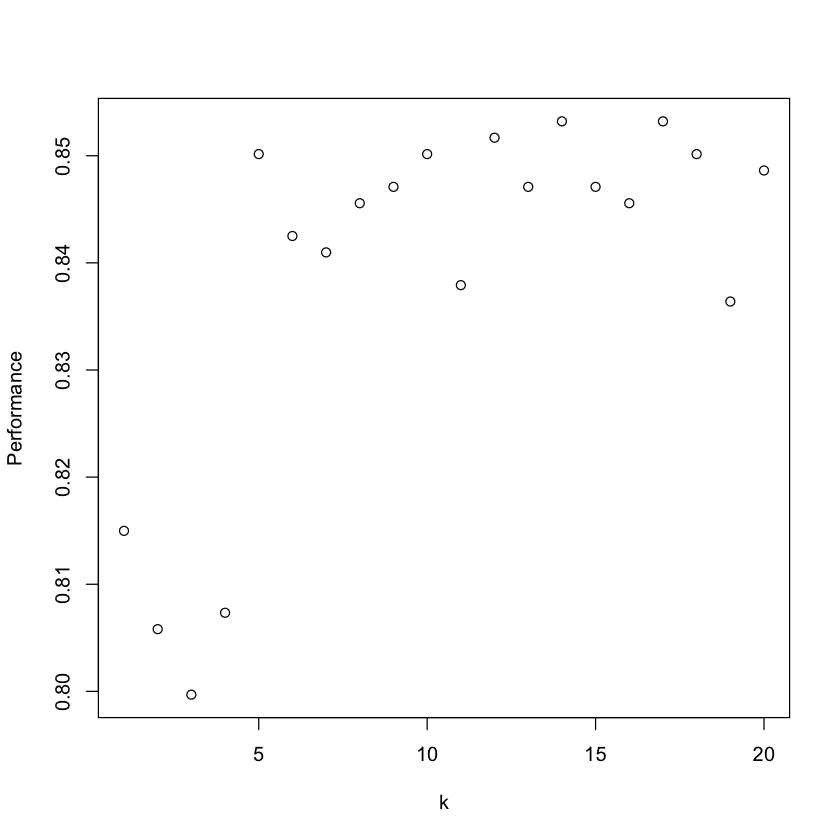

In [9]:
plot(data.frame("k" = kValues, "Performance" = performance))

The accuracy for k >= 5 looks very good. The exact values will vary from run to run, because of the randomness in splitting the data points into test and validation set.

- (b) splitting the data into training, validation, and test data sets (pick either KNN or SVM; the other is optional).

Using a ratio of 60/20/20 for splitting the data randomly into training, validation and test:

In [12]:
spec = c(train = .6, test = .2, validate = .2)

g = sample(cut(
    seq(nrow(data)),
    nrow(data) * cumsum(c(0, spec)),
    labels=names(spec)
))

split_data = split(data, g)

Check the resulting split:

In [14]:
sapply(split_data, nrow)/nrow(data)

train      test  validate 
0.5993884 0.2003058 0.2003058

The function knn_val(k) trains on the training set and returns the accuracy on the validation set:

In [26]:
knn_val <- function(k){
    model <- kknn(R1~.,
                  train=split_data$train,
                  test=split_data$validate,
                  k=k,
                  scale=TRUE)
    
    performance <- sum(round(fitted.values(model)) == split_data$validate$R1) / nrow(split_data$validate)
    
    return(performance)
}

Test different values for k:

In [34]:
kValues <- 1:50
performance <- c()

for (i in seq_along(kValues)) {   
    performance[i] <- knn_val(k=kValues[i])
}

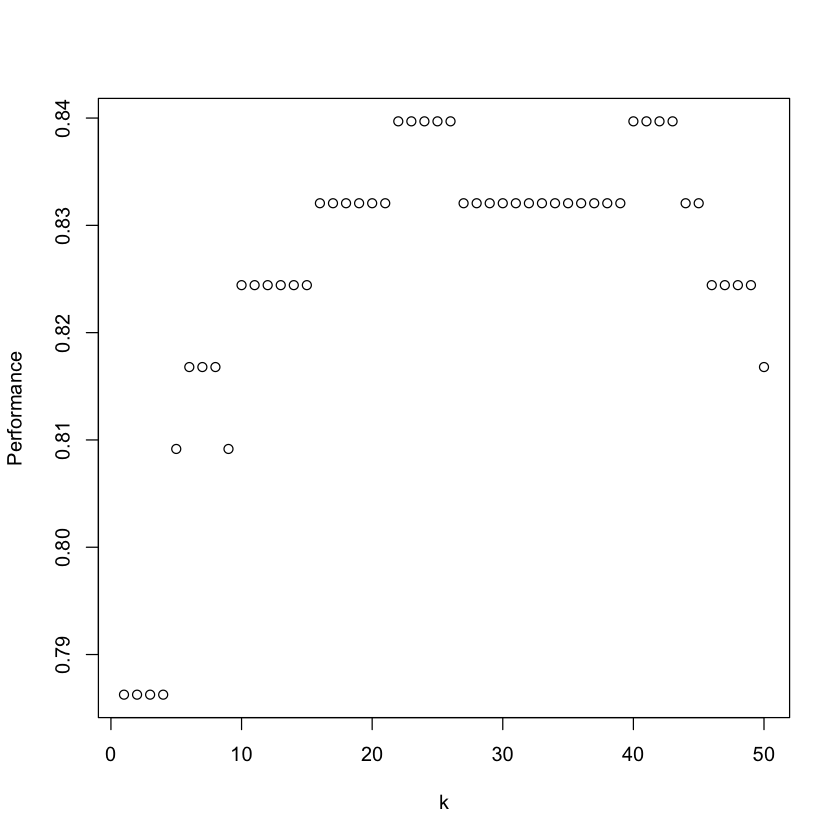

In [35]:
plot(data.frame("k" = kValues, "Performance" = performance))

In [36]:
max(performance)

[1] 0.8396947

In [37]:
kValues[which(performance==max(performance))]

[1] 22 23 24 25 26 40 41 42 43

The result suggests a value between 22 and 26 or 40 and 43 as the best pick.
Let's estimate the performance for k=24 on the test data set:

In [43]:
model <- kknn(R1~.,
              train=split_data$train,
              test=split_data$test,
              k=24,
              scale=TRUE)
    
sum(round(fitted.values(model)) == split_data$validate$R1) / nrow(split_data$validate)   

[1] 0.7251908

## Question 4.1

Describe a situation or problem from your job, everyday life, current events, etc., for which a clustering model would be appropriate. List some (up to 5) predictors that you might use.

To be able to recommend a new wine to a person, it would be helpful to cluster wines and suggest a wine in the same cluster than previously liked wines. Possible predictors to use for the clustering model are:
* Alcohol
* Acid
* Ash
* Flavanoids
* Color intensity

## Question 4.2
The iris data set iris.txt contains 150 data points, each with four predictor variables and one categorical response. The predictors are the width and length of the sepal and petal of flowers and the response is the type of flower. The data is available from the R library datasets and can be accessed with iris once the library is loaded. It is also available at the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Iris ). The response values are only given to see how well a specific method performed and should not be used to build the model.
  
Use the R function kmeans to cluster the points as well as possible. Report the best combination of predictors, your suggested value of k, and how well your best clustering predicts flower type.

In [56]:
library(datasets)

In [47]:
summary(iris)

  Sepal.Length    Sepal.Width     Petal.Length    Petal.Width   
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.057   Mean   :3.758   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
       Species  
 setosa    :50  
 versicolor:50  
 virginica :50  
                
                
                

Try cluster sizes from 1 to 10 with all four predictors:

In [94]:
tot_dist <- c()
clustering <- matrix(ncol=10, nrow=nrow(iris))

for (i in 1:10){
    cluster <- kmeans(iris[,1:4], i, nstart=10)
    
    clustering[,i] <- cluster$cluster
    tot_dist[i] <- cluster$tot.withinss
}

clustering = data.table(clustering)

Drawing an elbow graph from the results:

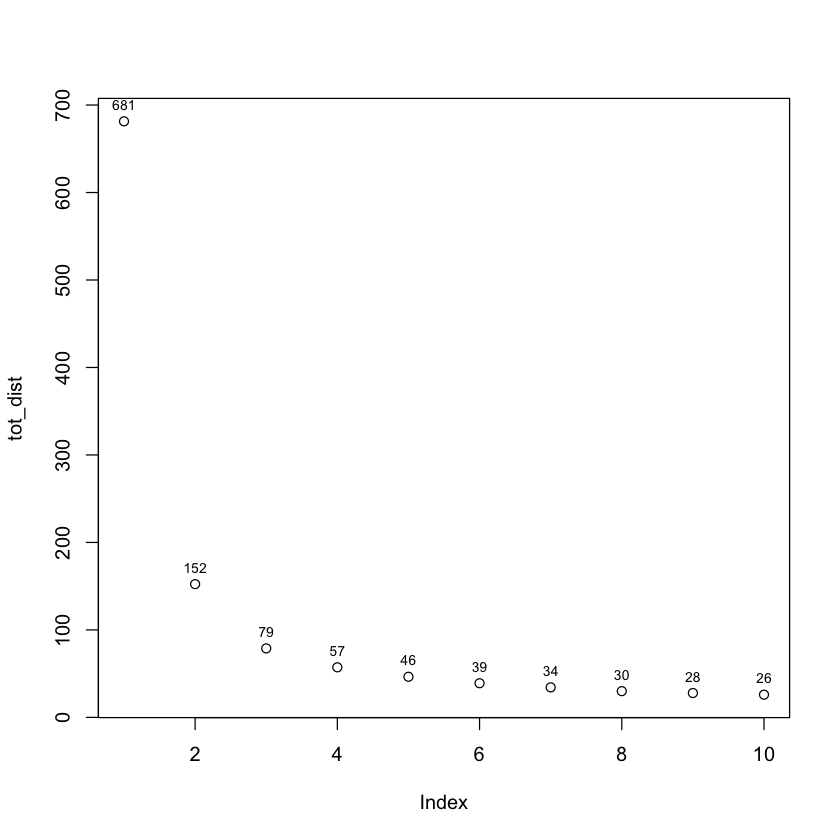

In [96]:
plot(tot_dist)
text(tot_dist, labels=round(tot_dist), cex= 0.7, pos=3)

The slope of the ellbow chart drops significantly at 3 clusters. 

If we check the result against the real plant classifications, we see that the seatosa and versicolor were clustered very well, while virginica was split between cluster one and two:

In [100]:
table(clustering$V3, iris$Species)

   
    setosa versicolor virginica
  1      0          2        36
  2      0         48        14
  3     50          0         0

To select other promising combinations of predictors, we can plot them:

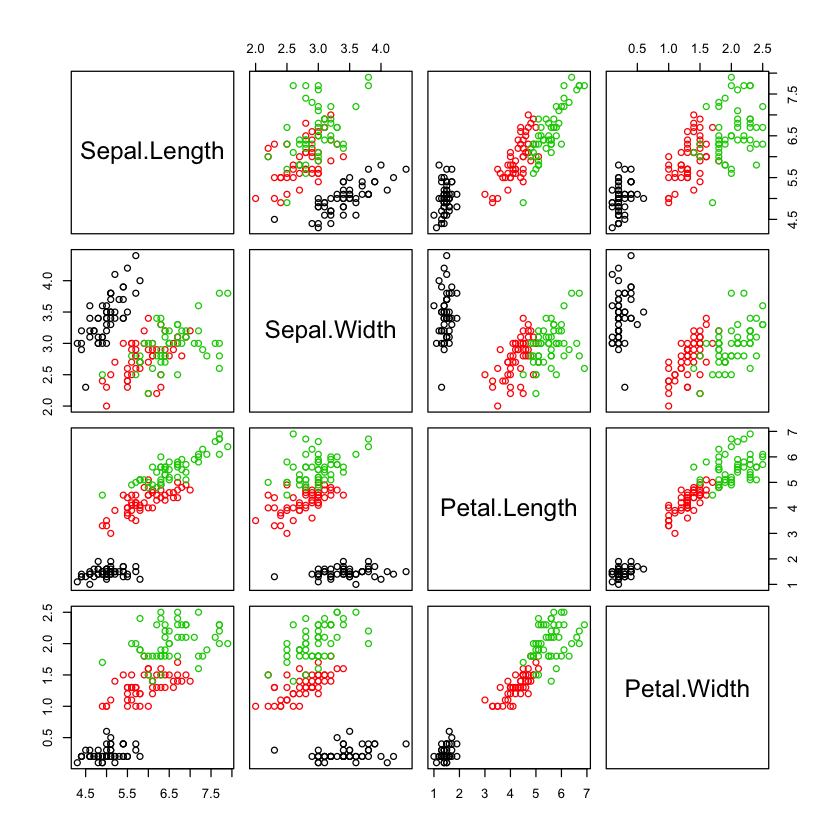

In [49]:
pairs(iris[,1:4], col=iris$Species)

The combination on petal length and petal width seems to divide the flowers well. Let's try cluster sizes from 1 to 10 with these predictors:

In [101]:
tot_dist <- c()
clustering <- matrix(ncol=10, nrow=nrow(iris))

for (i in 1:10){
    cluster <- kmeans(iris[,3:4], i, nstart=10)
    
    clustering[,i] <- cluster$cluster
    tot_dist[i] <- cluster$tot.withinss
}

clustering = data.table(clustering)

Drawing an elbow graph from the results:

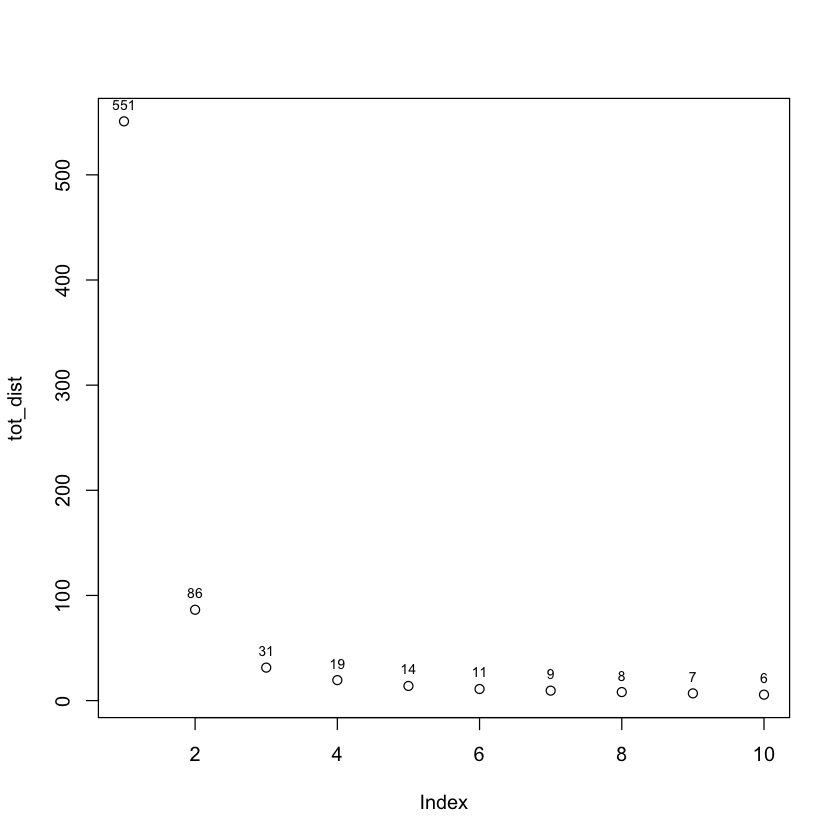

In [102]:
plot(tot_dist)
text(tot_dist, labels=round(tot_dist), cex= 0.7, pos=3)

The slope of the ellbow chart again drops at 3 clusters. 

If we check the result against the real plant classifications, we see that all flowers were clustered very well:

In [103]:
table(clustering$V3, iris$Species)

   
    setosa versicolor virginica
  1      0          2        46
  2     50          0         0
  3      0         48         4